## Извлечение отношений

Традиционно извлечение отношений решается как задача классификации. Нужно связать именованные сущности в предложении какими-то заранее известными типами связей. Чаще всего это отношения вроде work_at, born_in, located_in, head_of. В биомедициских текстах извлечение отношений применяется для извлечения взаимодействия белков и поиска пар (лекарство, болезнь). Количество аргументов вообще может быть любым, но чаще всего ограничиваются бинарными отношениями (субъект, предикат, объект). 

Посмотрим как это работает на размеченном датасете.

Данные - https://github.com/thunlp/FewRel/blob/master/data/train.json


FewRel - это датасет для few-shot обучения. Это немного другая задача, для которой нужна нейронная сеть с определенной архитектурой и тест сет тут состоит из отношений других типов. Подробнее про задачу и датасет можно почитать вот тут - https://arxiv.org/pdf/1810.10147v1.pdf.

Мы его будем использовать для обычной классификации. Оценивать качество будем на кросс-валидации.


In [1]:
import sys
sys.path.append('C:\Program Files\Anaconda3\Lib\site-packages')

In [1]:
import spacy

C:\Program Files\Anaconda3\envs\mllecture\lib\importlib\_bootstrap.py:222: RuntimeWarning: cymem.cymem.Pool size changed, may indicate binary incompatibility. Expected 48 from C header, got 64 from PyObject
  return f(*args, **kwds)
C:\Program Files\Anaconda3\envs\mllecture\lib\importlib\_bootstrap.py:222: RuntimeWarning: cymem.cymem.Address size changed, may indicate binary incompatibility. Expected 24 from C header, got 40 from PyObject
  return f(*args, **kwds)


In [3]:
print(spacy.__version__)

2.0.17


In [2]:
import json
import os
from collections import Counter
from itertools import combinations
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from scipy.sparse import hstack
from collections import defaultdict
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import spacy
nlp = spacy.load('en_core_web_sm')

Посмотрим на данные.

In [3]:
data = json.load(open('train.json'))

В датасете 64 типа отношений и у каждого типа 700 - предложений, в которых оно встречается.

In [4]:
len(data.keys())

64

Типы отношений обознчаются как-то условно, но в статье про датасет можно посмотреть соответствие.

In [9]:
data.keys()

dict_keys(['P306', 'P403', 'P1435', 'P17', 'P527', 'P407', 'P355', 'P710', 'P176', 'P937', 'P460', 'P264', 'P3450', 'P974', 'P1408', 'P140', 'P178', 'P4552', 'P123', 'P3373', 'P106', 'P800', 'P1346', 'P1344', 'P241', 'P6', 'P551', 'P991', 'P495', 'P150', 'P740', 'P1923', 'P156', 'P449', 'P466', 'P135', 'P1411', 'P86', 'P175', 'P159', 'P276', 'P1877', 'P84', 'P1001', 'P750', 'P101', 'P39', 'P706', 'P105', 'P137', 'P127', 'P400', 'P136', 'P57', 'P27', 'P118', 'P131', 'P58', 'P674', 'P102', 'P931', 'P1303', 'P22', 'P31'])

In [10]:
c = Counter([len(data[k]) for k in data])

In [11]:
c

Counter({700: 64})

Каждый инстанс - это предложения и разметка. Ключ h - это главное слово, t - зависимое. Предложения разделены на токены и в разметке указаны слова, уникальный номер и индексы сущности в предложении.

In [12]:
data['P127'][0]

{'h': ['babylon branch', 'Q4838506', [[7, 8]]],
 't': ['long island rail road', 'Q125943', [[11, 12, 13, 14]]],
 'tokens': ['Amityville',
  'is',
  'the',
  'westernmost',
  'station',
  'on',
  'the',
  'Babylon',
  'Branch',
  'of',
  'the',
  'Long',
  'Island',
  'Rail',
  'Road',
  'in',
  'Suffolk',
  'County',
  ',',
  'New',
  'York',
  '.']}

Для обучения нам нужно каким-то образом перевести такую разметку в один вектор и сопоставить ему тип отношения.

Как это сделать? 

Стандартный способ - достать контекст слева от первой сущности, между сущностями и после второй сущности. Левые и правые контексты можно ограничить каким-то числом (например, 3 слова). Для каждого контекста можно получить вектор обычными способами - например через TfidfVectorizer. Потом эти вектора конкатенируются в один.

Ещё в этот вектор можно добавить длину контекста, тэги сущностей, сами сущности, порядок сущностей и т.д.

In [5]:
# тут будем держать сущности
ent1 = []
ent2 = []

# тут будем хранить контексты
left = []
right = []
middle = []

# целые предложения тоже на всякий случай достанем
sents = []

# целевая переменная (тип отношений будет тут)
target = []


# проходим по типам отношений
for key in data:
    # по каждому инстансу
    for instance in data[key]:
        
        tokens = instance['tokens']
        sents.append(tokens)
        
        ent1.append(' '.join([tokens[i] for i in instance['h'][2][0]]))
        ent2.append(' '.join([tokens[i] for i in instance['t'][2][0]]))
        
        
        # h и t не обязательно идут в таком порядке
        # чтобы достать контексты нужно понять что из них идет первым
        if instance['h'][2][0][0] < instance['t'][2][0][0]:
            first, second = 'h', 't'
        else:
            second, first = 'h', 't'
        
        
        # индексы сущностей
        first_start = instance[first][2][0][0]
        first_end = instance[first][2][0][-1]
        second_start = instance[second][2][0][0]
        second_end = instance[second][2][0][-1]

        # левый контекст - это три слова слева от начала первой сущности
        # если слева меньше 3 слов, то добавим тэгов <START>
        left_context = tokens[max(0, first_start-3):first_start]
        left.append((['<START>']*(3-len(left_context))) + left_context)
        
        # правый контекст - это 3 слова после последнего слова второй сущности
        # если справа меньше 3 слов, то добавим тэгов <END>
        right_context = tokens[second_end+1:second_end+4]
        right.append(right_context + (['<END>']*(3-len(right_context))))

        # средний контекст - это слова между последний словом первой сущности 
        # и первым словом второй сущности
        middle_context = tokens[first_end+1:second_start]
        middle.append(middle_context)

        target.append(key)
        
        

Для тфидф векторайзера склеим токены. Обучим один общий векторайзер на всех текстах, но можно для каждого контекста обучить свой. 

In [6]:
lefts_s = [' '.join(l) for l in left]
rights_s = [' '.join(l) for l in right]
middles_s = [' '.join(l) for l in middle]

tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1,2))
tfidf.fit(lefts_s + rights_s + middles_s)

l = tfidf.fit_transform(lefts_s)
r = tfidf.fit_transform(rights_s)
m = tfidf.fit_transform(middles_s)

X = csr_matrix(hstack([l,m,r])) # чтобы можно было по индексам доставать

In [46]:
l.shape

(44800, 3000)

In [7]:
X.shape

(44800, 9000)

In [8]:
y = np.array(target)

Оценим качество на StratifiedKFold. Посчитаем стандартные метрики (c микро и макро усреднением). Ещё сделаем матрицу ошибок.

In [22]:
N = 4
skf = StratifiedKFold(n_splits=N, shuffle=True)
metrics_macro = np.zeros((3))
metrics_micro = np.zeros((3))
conf = np.zeros((len(set(y)), len(set(y))))

for train_index, test_index in skf.split(X, y):
    # Можно конечно что-нибудь посложнее, но для примера хватит и логрега
    clf = LogisticRegression()
    clf.fit(X[train_index], y[train_index])
    preds = clf.predict(X[test_index])
    
    metrics_macro += precision_recall_fscore_support(y[test_index], preds, average='macro')[:3]
    metrics_micro += precision_recall_fscore_support(y[test_index], preds, average='micro')[:3]
    
    conf += confusion_matrix(y[test_index], preds)
    

In [23]:
print(metrics_micro/N)
print(metrics_macro/N)

[0.47345982 0.47345982 0.47345982]
[0.46980638 0.47345982 0.46631427]


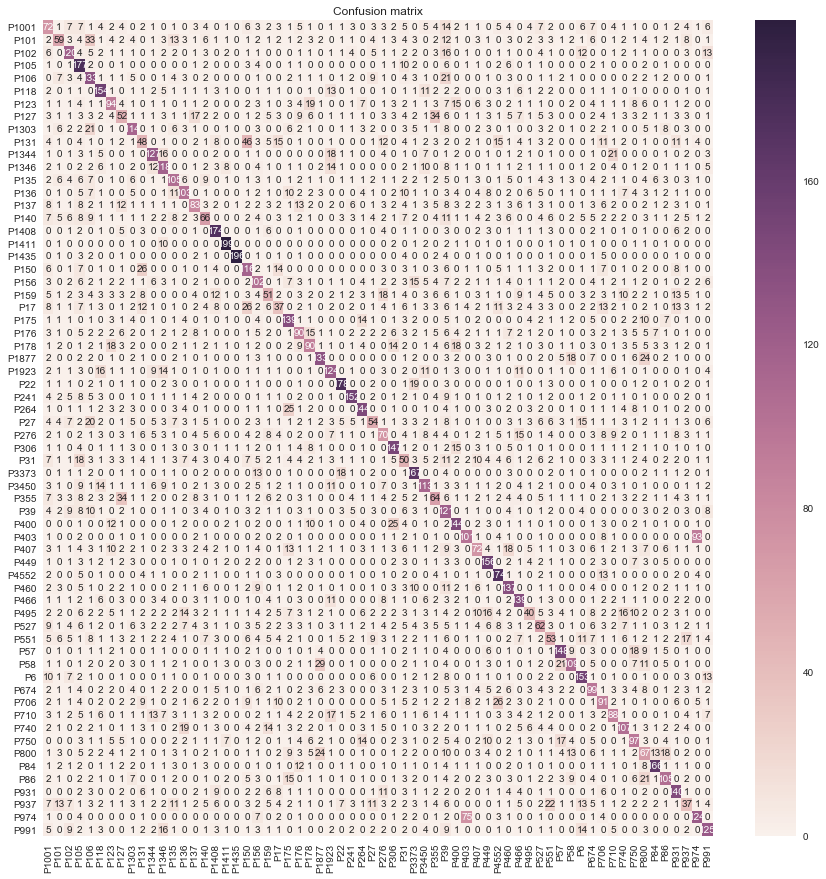

In [24]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(data=np.round(conf/3).astype(int), 
            annot=True, 
            fmt="d", xticklabels=clf.classes_, yticklabels=clf.classes_, ax=ax)
plt.title("Confusion matrix")
plt.show()

Качество получается не очень хорошее. Но для такой сложной задачи (и не очень подходящего датасета) - это нормально.

Это качество ещё сильнее ухудшится, если мы захотим применить классификатор на неразмеченных текстах. В этом датасете нам сразу даны разметки именованных сущностей. В реальной задаче - их нужно находить самим.

In [ ]:
Попробуем другой классификатор

In [12]:
from sklearn.svm import LinearSVC

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

In [21]:
N = 4
skf = StratifiedKFold(n_splits=N, shuffle=True)
metrics_macro = np.zeros((3))
metrics_micro = np.zeros((3))
conf = np.zeros((len(set(y)), len(set(y))))

for train_index, test_index in skf.split(X, y):
    # clf = OneVsRestClassifier(LogisticRegression(), n_jobs=-1)
    clf = LinearSVC(C = 0.1)
    clf.fit(X[train_index], y[train_index])
    preds = clf.predict(X[test_index])
    
    metrics_macro += precision_recall_fscore_support(y[test_index], preds, average='macro')[:3]
    metrics_micro += precision_recall_fscore_support(y[test_index], preds, average='micro')[:3]
    
    conf += confusion_matrix(y[test_index], preds)
    

In [14]:
print(metrics_micro/N)
print(metrics_macro/N)

[0.47832589 0.47832589 0.47832589]
[0.46305705 0.47832589 0.46373521]


In [ ]:
Качество практически не изменилось

In [ ]:
Попробуем использовать эмбеддинги контекстов. Возьмем предобученные эмебеддинги FastText

In [9]:
from tqdm import tqdm_notebook

In [10]:
embed_model = 'D:/wiki.ru.vec'

In [11]:
words = []

embeddings_index = {}
fo = open(embed_model, encoding = 'utf-8')
for line in tqdm_notebook(fo):
    values = line.split()
    if len(values) == 301:
        word = values[0]
        words.append(word)
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
fo.close()

In [24]:
data['P140'][10]

{'h': ['saint thaddeus and bartholomew cathedral',
  'Q4505122',
  [[19, 20, 21, 22, 23]]],
 't': ['armenian apostolic', 'Q683724', [[17, 18]]],
 'tokens': ['In',
  'the',
  '1930s',
  ',',
  'the',
  'cathedral',
  'was',
  'ordered',
  'to',
  'be',
  'blown',
  'up',
  'with',
  'dynamite',
  'along',
  'with',
  'the',
  'Armenian',
  'Apostolic',
  'Saint',
  'Thaddeus',
  'and',
  'Bartholomew',
  'Cathedral',
  '.']}

In [26]:
print(embeddings_index['cathedral'])

[-4.8498e-02  5.6923e-01 -1.1765e-01 -1.1594e+00  1.7373e-01 -3.6135e-01
  4.5966e-01 -1.4542e-01  3.2940e-01  1.6666e-01 -5.3245e-01 -8.5912e-02
  8.3388e-01  6.1648e-01 -2.9096e-01  8.3481e-01 -1.1149e-01  2.2140e-01
  8.7524e-01  7.4038e-01 -2.2253e-01 -2.9715e-01  1.9319e-01 -2.3405e-01
 -1.3148e-01 -3.7025e-01  2.9575e-03 -5.5433e-01  3.2764e-01  8.7292e-02
 -8.1450e-01 -2.1459e-01  4.4897e-01 -1.5799e-01  4.1369e-01  1.3883e-01
 -1.1033e-01 -4.7904e-01  2.0756e-01  8.4868e-02  3.6628e-01  3.1109e-01
  2.7344e-01  1.8926e-01 -3.8929e-01 -9.3350e-02  4.5505e-01 -2.8094e-01
  5.0769e-01 -1.2078e-01 -2.8004e-01 -3.3109e-01  3.3676e-01 -1.7068e-01
  4.8495e-01 -2.2718e-01  4.2665e-01  6.9147e-02 -9.0421e-02 -1.8073e-01
  8.8692e-02  1.3208e-01  2.3288e-01  2.7568e-01 -2.9648e-01  3.1120e-01
 -6.1988e-01  4.3978e-01  5.3811e-01 -5.0662e-01  6.5861e-01  3.2892e-01
 -8.6058e-02 -2.2631e-01  8.9216e-01  4.2283e-02 -5.1853e-01 -4.2291e-01
 -7.3178e-02 -7.6071e-01  3.3311e-01 -3.1197e-01  4

In [27]:
def get_embedding(text, model, dim):
    text = text.split()
    words = Counter(text)
    total = len(text)
    vectors = np.zeros((len(words), dim))
    
    for i,word in enumerate(words):
        try:
            v = model[word]
            vectors[i] = v*(words[word]/total) 
        except (KeyError, ValueError):
            continue
    
    if vectors.any():
        vector = np.average(vectors, axis=0)
    else:
        vector = np.zeros((dim))
    
    return vector

In [28]:
dim = 300
left = np.zeros((len(lefts_s), dim))
right = np.zeros((len(rights_s), dim))
mid = np.zeros((len(middles_s), dim))

for i, text in enumerate(lefts_s):
    left[i] = get_embedding(text, embeddings_index, dim)
    
for i, text in enumerate(rights_s):
    right[i] = get_embedding(text, embeddings_index, dim)
    
for i, text in enumerate(middles_s):
    mid[i] = get_embedding(text, embeddings_index, dim)

In [29]:
left.shape

(44800, 300)

In [30]:
type(left)

numpy.ndarray

In [31]:
X = np.concatenate((left, mid, right), axis = 1)

In [32]:
X.shape

(44800, 900)

In [33]:
N = 4
skf = StratifiedKFold(n_splits=N, shuffle=True)
metrics_macro = np.zeros((3))
metrics_micro = np.zeros((3))
conf = np.zeros((len(set(y)), len(set(y))))

for train_index, test_index in tqdm_notebook(skf.split(X, y)):
    clf = LinearSVC(C = 0.1)
    clf.fit(X[train_index], y[train_index])
    preds = clf.predict(X[test_index])
    
    metrics_macro += precision_recall_fscore_support(y[test_index], preds, average='macro')[:3]
    metrics_micro += precision_recall_fscore_support(y[test_index], preds, average='micro')[:3]
    
    conf += confusion_matrix(y[test_index], preds)
    

In [34]:
print(metrics_micro/N)
print(metrics_macro/N)

[0.37006696 0.37006696 0.37006696]
[0.36647735 0.37006696 0.34530632]


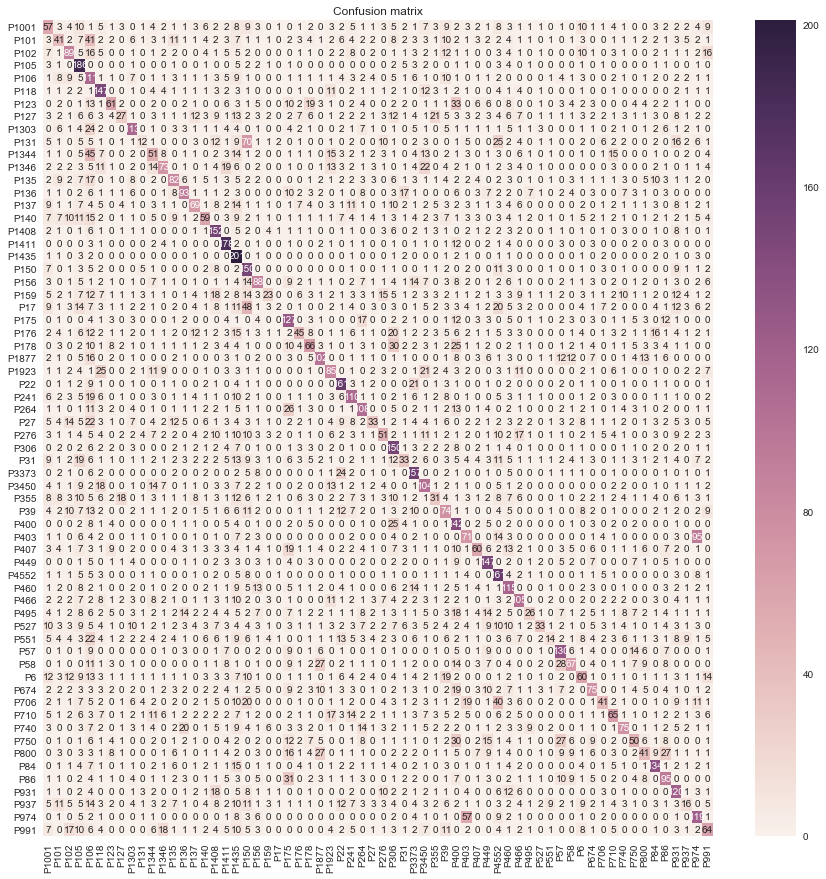

In [35]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(data=np.round(conf/3).astype(int), 
            annot=True, 
            fmt="d", xticklabels=clf.classes_, yticklabels=clf.classes_, ax=ax)
plt.title("Confusion matrix")
plt.show()

Результат сильно хуже, чем на векторах TFIDF. По матрице видно, что часто путается класс P131 и P150. <br>
    1. P131 - "located in the administrative territorial entity", <br>
    2. P150 - "contains administrative territorial entity". <br>
Оба отношения связаны с территориальными единицами (расположен на территории чего-либо, включает территориальную единицу) и  могут встречаться в похожих контекстах.
Примеры:

In [37]:
data['P131'][0]

{'h': ['memphis', 'Q962034', [[8]]],
 't': ['scotland county, missouri', 'Q496971', [[10, 11, 12, 13]]],
 'tokens': ['Downing',
  'House',
  'is',
  'a',
  'historic',
  'home',
  'located',
  'at',
  'Memphis',
  ',',
  'Scotland',
  'County',
  ',',
  'Missouri',
  '.']}

In [38]:
data['P150'][0]

{'h': ['saudi arabia', 'Q851', [[19, 20]]],
 't': ['jizan province', 'Q269973', [[16, 17]]],
 'tokens': ['The',
  'sailor',
  'was',
  'rescued',
  'by',
  'Saudi',
  'Arabian',
  'border',
  'guards',
  'in',
  'the',
  'Red',
  'Sea',
  'and',
  'taken',
  'to',
  'Jizan',
  'Province',
  'of',
  'Saudi',
  'Arabia',
  '.']}

Другой пример плохо определенных отношений: P403, P974. <br>
    1. P403 - mouth of the watercourse (the body of water to which the watercourse drains)
    2. P974 - stream or river that flows into this main stem (or parent) river
Снова близкие по тематике отношения.

In [40]:
data['P403'][0]

{'h': ['mackenzie', 'Q3411', [[22]]],
 't': ['beaufort sea', 'Q131274', [[15, 16]]],
 'tokens': ['The',
  'Peel',
  'watershed',
  'drains',
  '14',
  '%',
  'of',
  'the',
  'Yukon',
  'Territory',
  'Canada',
  'and',
  'flows',
  'into',
  'the',
  'Beaufort',
  'Sea',
  'via',
  'the',
  'Peel',
  'and',
  'then',
  'Mackenzie',
  'Rivers',
  '.']}

In [41]:
data['P974'][0]

{'h': ['hudson river', 'Q3140', [[18, 19]]],
 't': ['schroon river', 'Q7432908', [[14, 15]]],
 'tokens': ['The',
  'east',
  'side',
  'of',
  'Grace',
  'Peak',
  'drains',
  'into',
  'Lindsay',
  'Brook',
  ',',
  'thence',
  'into',
  'the',
  'Schroon',
  'River',
  ',',
  'the',
  'Hudson',
  'River',
  ',',
  'and',
  'into',
  'New',
  'York',
  'Bay',
  '.']}

Посмотрим как это работает на каких-нибудь новостных текстах. Именованные сущности достанем с помощью spacy.

Новостные тексты взяты отсюда - https://webhose.io/datasets/

In [ ]:
files = os.listdir('news')

In [ ]:
doc = json.load(open('news/'+files[0]))

Тут полно метаинформации, но нам нужны только тексты.

In [ ]:
doc

In [ ]:
doc = nlp(doc['text'])

Spacy сразу достает сущности.

In [ ]:
for ent in doc.ents:
    print(ent.string, ent.label_)

Тут много разных типов сущностей. Возьмем только PERSON и ORG (GPE тоже скорее организация, поэтому включим её тоже).

Нас интересуют только предложения, в которых есть хотя бы одна персона и одна организация.

In [ ]:
sents_with_ents = []

for file in files:
    js = json.load(open('news/'+file))
    text = js['text']
    doc = nlp(text)
    
    
    for sent in doc.sents:
        sent = sent.as_doc()
        pers = []
        orgs = []
        for entity in sent.ents:
            if entity.label_ == 'PERSON':
                pers.append(entity)
            elif entity.label_ in ['ORG', 'GPE']:
                orgs.append(entity)
        if pers and orgs:
            sents_with_ents.append((sent, pers, orgs))
                
                


Теперь точно также извлечем контексты вокруг сущностей. Единственное отличие - нам нужно учитывать случаи, когда в одном предложении сразу несколько сущностей. Просто переберем все сочетания персон с организациями. 

In [ ]:
lefts = []
ents1 = []
ents2 = []
rights = []
middles = []
orders = []
sents = []
tags = []
for sent, pers, orgs in sents_with_ents:
    for per in pers:
        # пары с этой персоной и остальными организациями
        pairs = [[per, org] for org in orgs]
        
        sent = list(sent)
        
        for ent1, ent2 in pairs:
            sents.append(' '.join([str(w) for w in sent]))
            if ent1.start > ent2.start:
                ent2, ent1 = ent1, ent2

            # ent.start в spacy совпадает с начальным токеном
            # а вот ent.end - это номер последнего токена + 1
            # поэтому этот кусок немного отличается
            left_context = sent[max(0, ent1.start-3):ent1.start]
            lefts.append(['<START>']*(3-len(left_context)) + left_context)
            
            right_context = sent[ent2.end:ent2.end+3]
            rights.append(right_context + (['<END>']*(3-len(right_context))))
            
            middles.append(sent[ent1.end:ent2.start])
            
            ents1.append(ent1.string)
            ents2.append(ent2.string)
            
            tags.append([ent1.label_, ent2.label_])

            

In [ ]:
len(lefts)

Посмотрим какие вообще пары сущностей достались.

In [ ]:
entpair = ['#'.join(e) for e in zip(ents1, ents2)]

In [ ]:
Counter(entpair).most_common()

Почему-то выделяются новые строки. Но попробуем с ними.

In [ ]:
lefts_s = [' '.join([str(x) for x in l]) for l in lefts]
rights_s = [' '.join([str(x) for x in l]) for l in rights]
middles_s = [' '.join([str(x) for x in l]) for l in middles]


In [ ]:
len(lefts_s)

In [ ]:
# tfidf = TfidfVectorizer(max_features=3000)
# tfidf.fit(lefts_s + rights_s + middles_s)

In [ ]:
l = tfidf.transform(lefts_s)
r = tfidf.transform(rights_s)
m = tfidf.transform(middles_s)

In [ ]:
X_ = hstack([l,m,r])

In [ ]:
X_.shape

Теперь посмотрим на то, как предсказывается какой-нибудь класс.

In [ ]:
list(clf.classes_).index('P118')

In [ ]:
pred = clf.predict_proba(X_)[:, 5]

In [ ]:
list(zip(np.array(sents)[pred > 0.3], np.array(entpair)[pred > 0.3]))

Тема вроде бы распознается, но отношения выделяются не очень хорошо.

Можно попробовать кластеризовать предложения. Вдруг какие-то отношения выделятся в кластер.

In [ ]:
cluster = MiniBatchKMeans(100, verbose=1, reassignment_ratio=0.3, max_no_improvement=500)
cluster.fit(X_)

In [ ]:
cl2id = defaultdict(list)

for i, cl in enumerate(cluster.labels_):
    cl2id[cl].append(i)


In [ ]:
len(entpair)

In [ ]:
f = open('clusters.txt', 'w')

for cl in cl2id:
    f.write('CLUSTER __' + str(cl) + '__\n')
    for i in cl2id[cl]:
        f.write(entpair[i].replace('\n', ' ') + '\n')
        f.write(sents[i].replace('\n', ' ') + '\n')
    f.write('\n\n')
f.close()

## Другие подходы

Для нейросетей задачу можно представить как seq2seq - каждому токену соответствует тэг H, T или O (можно добавить Begin, Inside тэги, чтобы отметить многословные сущности). И можно вообще решать задачу извлечения сущностей и отношений вместе. Про это читать,
например, тут:  https://www.semanticscholar.org/paper/Joint-learning-of-named-entity-recognition-and-Xu-Li/31ce449618068343f9f83c904c7fd062ba943c8e?navId=references

Извлечение отношений часто пытаются решать без учителя. 

Один из подходов - **bootstrapping**, о котором мы говорили в прошлый раз. Можно выбрать какой-то набор пар сущностей, которые выражают отношение и найти предложения, в которых эта пара сущностей встречается. Потом найти похожие по контекстам предложения и считать их представителями этого класса. Затем можно достать пары сущностей, в которых они употреблены и повторить все заново. 

Про это можно почитать вот тут:

1) одна из первых работ - https://pdfs.semanticscholar.org/6f16/7cce628ec4983788ddf21587630afebf43ce.pdf?_ga=2.136426931.2051797770.1542970757-1216332217.1520769589 (от создателя гугла)

2) https://pdfs.semanticscholar.org/189e/d3f749766d02d42eb5b6d71017e085c212d4.pdf?_ga=2.112375175.2051797770.1542970757-1216332217.1520769589

3) Тут бустраппинг делается с помощью word2vec -https://pdfs.semanticscholar.org/fe6e/56ec0a1f5d673a4ab22e716f2c846b497f9c.pdf?_ga=2.179043751.2051797770.1542970757-1216332217.1520769589



Другой популярный метод - **distant supervision**. Идея очень похожая, только вместо того, чтобы самим придумывать положительные примеры - их берут из какой-нибудь базы данных. Например, из DBPedia или из Freebase. Достав большое количество упоминаний, можно собрать уже достаточно большую обучающую выборку.

Почитать можно тут:  
1) первая статья по теме (от журафского) https://www.semanticscholar.org/paper/Distant-supervision-for-relation-extraction-without-Mintz-Bills/8f8139b63a2fc0b3ae8413acaef47acd35a356e0  
    
2) тут предлагаются методы убрать шум из такой разметки - https://www.semanticscholar.org/paper/Denoising-Distant-Supervision-for-Relation-via-Han-Liu/3d13ee24493a6c2a0477b15e5145ba5868c3df40 
    
   

Ещё одно большое направление - Open Information Extraction. Идея тут в том, чтобы извлекать из предложений (или текстов) все отношения в виде троек (субъект, предикат, объект). 

Например, из предложения __The U.S. president Barack Obama gave his speech on Tuesday and Wednesday to thousands of people.__ излекутся тройки:  

__(Barack Obama, president, U.S)  
(Barack Obama, gave, his speech)  
(Barack Obama, gave his speech, on Tuesday)  
(Barack Obama, gave his speech, on Wednesday)  
(Barack Obama, gave his speech, to thousands of people)__

Таким образом можно извлекать неограниченное количество типов отношений, т.е. не нужно для каждого типа размечать предложения. Однако появляется необходимость каким-то образом кластеризовать разные способы выражения одного типа отношений. 

Почитать про OpenIE можно тут:

1) оригинальная работа http://www.aaai.org/Papers/IJCAI/2007/IJCAI07-429.pdf  
2) одна из самых известных работ http://ml.cs.washington.edu/www/media/papers/reverb_emnlp2011.pdf  
3) одна из последних статей http://www.cse.iitd.ac.in/~mausam/papers/coling18.pdf  

Реализация OpenIE есть StandfordNLP и вот тут - https://github.com/dair-iitd/OpenIE-standalone